In [2]:
library(rhdf5)
library(MASS)
library(broom)
# library(pscl)

# Test reading h5 and accessing data

In [3]:
fh <- "../simulated_data/sim.h5"

Get internal structure of h5 file

In [4]:
h5ls(fh)

,group,name,otype,dclass,dim
,<chr>,<chr>,<chr>,<chr>,<chr>
0,/,coeffs,H5I_DATASET,COMPOUND,13000
1,/,counts,H5I_DATASET,INTEGER,13000 x 50000
2,/,guides,H5I_GROUP,,
3,/guides,est_efficiency_D10,H5I_DATASET,FLOAT,2000
4,/guides,est_efficiency_D100,H5I_DATASET,FLOAT,2000
5,/guides,metadata,H5I_DATASET,COMPOUND,2000
6,/guides,one_hot,H5I_DATASET,INTEGER,50000 x 2000
7,/,linear_predictor,H5I_DATASET,FLOAT,13000 x 50000
8,/,mu,H5I_DATASET,FLOAT,13000 x 50000


Test reading first row from counts matrix

In [4]:
system.time(row.counts <- h5read(file = fh, name = "counts", index = list(1, 1:50000)))

   user  system elapsed 
  0.875   0.124   1.000 

In [5]:
row.counts

0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0


Check if this matches

In [6]:
counts.mtx <- h5read(fh, "counts")
dim(counts.mtx)
counts.mtx[1,1:10]

[1] 13000 50000

[1] 0 0 0 0 0 0 0 0 0 0

Try pulling a row from matrix of $X_1$

In [7]:
system.time(row.vars <- h5read(file = fh, name = "x/x1", index = list(1, 1:50000)))

   user  system elapsed 
  0.489   0.014   0.503 

In [8]:
sum(row.vars)

[1] 0

Check if this is correct

In [9]:
x1.mtx <- h5read(fh, "x/x1")
sum(x1.mtx[1,1:50000])

[1] 0

# Load fixed values

Coefficients (ground truth for evaluating model performance) 

Cell cycle scores (same for every gene)

In [7]:
coeffs <- h5read(file = fh, name = "coeffs")
cell.cycle.scores <- h5read(fh, "x/cell_cycle_scores")
scaling.factors <- h5read(file = fh, name = "scaling_factors")
guides.metadata <- h5read(file = fh, name = "guides/metadata")
percent.mito <- h5read(file = fh, name = "x/percent_mito")

est.eff.d100 <- h5read(file = fh, name = "guides/est_efficiency_D100")
est.eff.d10 <- h5read(file = fh, name = "guides/est_efficiency_D10")
est.eff <- data.frame(d100=est.eff.d100, d10 = est.eff.d10)

In [11]:
head(est.eff)

,d100,d10
,<dbl>,<dbl>
1,0.5076415,0.6898476
2,0.4982986,0.5571219
3,0.5476307,0.6325339
4,0.4776489,0.4308420
5,0.4861400,0.5816943
6,0.4624721,0.4790031


In [12]:
head(guides.metadata)

,target.gene,efficiency,effect.size
,<int>,<dbl>,<dbl>
1,11834,0.6972342,-1.513900
2,7767,0.6782246,-3.606096
3,429,0.6357277,-4.834780
4,8881,0.5748017,-3.036978
5,6743,0.7808839,-1.485520
6,10113,0.8382174,-3.738202


In [67]:
coeffs[1,]

,baselines,beta1,beta2,beta3,beta4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-3.466879,0,4.817536,3.715494,3.142712


# Calculate inputs used to generate simulated counts

In [68]:
compute.mu <- function(gene, x1, x2, x3, x4, betas = coeffs, scale = scaling.factors) {
    beta0 <- betas[gene,]$baselines
    beta1 <- betas[gene,]$beta1
    beta2 <- betas[gene,]$beta2
    beta3 <- betas[gene,]$beta3
    beta4 <- betas[gene,]$beta4
    mu <- beta0 + beta1*x1 + beta2*x2 + beta3*x3 + beta4*x4 + log(scale)
    return(mu)
}

In [71]:
mu.list <- list()
mean.list <- list()

for (gene in 1:13000) {
    x1 <- as.integer(h5read(file = fh, name = "x/x1", index = list(gene, 1:50000)))
    mu <- compute.mu(gene, x1, cell.cycle.scores$s.scores, cell.cycle.scores$g2m.scores, percent.mito)
    mean.list[[gene]] <- exp(mu)
    mu.list[[gene]] <- mu
}

# Define null and alternative models

## Model
$$y = \text{NB}(\mu=s \cdot \exp \left( \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 \right), n=\sigma)$$
### $H_0: \beta_1 = 0 $
### $H_A: \beta_1 \neq 0 $



### Test for one gene with `glm.nb` (MASS library)

Gene with no targeted enhancer - we expect $\beta_1=0$ and $H_0$ to be a better model fit.

In [28]:
test.gene <- sample(setdiff(c(1:13000),guides.metadata$target.gene),1)
print(test.gene)
obs.counts <- h5read(file = fh, name = "counts", index = list(test.gene, 1:50000))
gene.data <- data.frame(guide.eff = as.integer(h5read(file = fh, name = "x/x1", index = list(test.gene, 1:50000))),
                       s.score = cell.cycle.scores$s.scores,
                       g2m.score = cell.cycle.scores$g2m.scores,
                        percent.mito = percent.mito,
                       counts = as.integer(obs.counts),
                       scaling.factor = scaling.factors)

[1] 1985


In [29]:
head(gene.data)

,guide.eff,s.score,g2m.score,percent.mito,counts,scaling.factor
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,0,1.7947199,-1.83639354,0.06061820,1,0.050330
2,0,-0.2756066,1.50885110,0.03715752,2,0.050085
3,0,0.7234078,0.09391965,0.05300308,3,0.050013
4,0,0.7588188,-1.47243103,0.04361673,0,0.050187
5,0,-1.3408158,1.06949958,0.03769811,0,0.050154
6,0,0.3849191,0.48729077,0.03390487,3,0.049889


In [30]:
system.time(ml <- glm.nb(counts ~ guide.eff + s.score + g2m.score + percent.mito + offset(log(scaling.factor)), 
                         data = gene.data,
                        control = glm.control(maxit = 1000)))

   user  system elapsed 
 25.174  22.548   3.168 

In [31]:
summary(ml)


Call:
glm.nb(formula = counts ~ guide.eff + s.score + g2m.score + percent.mito + 
    offset(log(scaling.factor)), data = gene.data, control = glm.control(maxit = 1000), 
    init.theta = 1.487163167, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1539  -0.7918  -0.3976   0.1242   4.0767  

Coefficients: (1 not defined because of singularities)
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   2.31599    0.01449 159.887   <2e-16 ***
guide.eff          NA         NA      NA       NA    
s.score       3.27219    0.01294 252.910   <2e-16 ***
g2m.score     2.16064    0.01149 187.967   <2e-16 ***
percent.mito  2.63130    0.28905   9.103   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.4872) family taken to be 1)

    Null deviance: 198668  on 49999  degrees of freedom
Residual deviance:  39633  on 49996  degrees of freedom
AIC: 136413

Number of Fisher Scoring

In [32]:
coeffs[test.gene,]

,baselines,beta1,beta2,beta3,beta4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1985,2.321372,0,3.247074,2.154742,2.812768


In [33]:
system.time(ml.null <- update(ml, . ~ . - guide.eff))

   user  system elapsed 
 17.044  15.380   2.074 

In [34]:
summary(ml.null)


Call:
glm.nb(formula = counts ~ s.score + g2m.score + percent.mito + 
    offset(log(scaling.factor)), data = gene.data, control = glm.control(maxit = 1000), 
    init.theta = 1.487163236, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1539  -0.7918  -0.3976   0.1242   4.0767  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   2.31599    0.01449 159.887   <2e-16 ***
s.score       3.27219    0.01294 252.910   <2e-16 ***
g2m.score     2.16064    0.01149 187.967   <2e-16 ***
percent.mito  2.63130    0.28905   9.103   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.4872) family taken to be 1)

    Null deviance: 198668  on 49999  degrees of freedom
Residual deviance:  39633  on 49996  degrees of freedom
AIC: 136413

Number of Fisher Scoring iterations: 1


              Theta:  1.4872 
          Std. Err.:  0.0211 

 2 x log-likelihood:  -136402

In [35]:
anova(ml, ml.null)

Model,theta,Resid. df,2 x log-lik.,Test,df,LR stat.,Pr(Chi)
<chr>,<dbl>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>
guide.eff + s.score + g2m.score + percent.mito + offset(log(scaling.factor)),1.487163,49996,-136402.6,,NA,NA,NA
s.score + g2m.score + percent.mito + offset(log(scaling.factor)),1.487163,49996,-136402.6,1 vs 2,0,8.731149e-11,0


In [37]:
ml.null$aic < ml$aic

[1] TRUE

### Test for one gene
Gene with targeted enhancer - we expect $beta_1\neq0$ and $H_A$ to be a better model fit

In [61]:
test.gene <- sample(guides.metadata$target.gene, 1)
test.gene

obs.counts <- h5read(file = fh, name = "counts", index = list(test.gene, 1:50000))
gene.data <- data.frame(guide.eff = as.integer(h5read(file = fh, name = "x/x1", index = list(test.gene, 1:50000))),
                       s.score = cell.cycle.scores$s.scores,
                       g2m.score = cell.cycle.scores$g2m.scores,
                        percent.mito = percent.mito,
                       counts = as.integer(obs.counts),
                       scaling.factor = scaling.factors)

[1] 7001

In [45]:
system.time(ml <- glm.nb(counts ~ guide.eff + s.score + g2m.score + percent.mito + offset(log(scaling.factor)), 
                         data = gene.data,
                        control = glm.control(maxit = 1000)))

   user  system elapsed 
 32.508  28.954   5.293 

In [46]:
summary(ml)


Call:
glm.nb(formula = counts ~ guide.eff + s.score + g2m.score + percent.mito + 
    offset(log(scaling.factor)), data = gene.data, control = glm.control(maxit = 1000), 
    init.theta = 1.487808264, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5570  -0.6985  -0.2940  -0.0239   3.5886  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   2.08646    0.01529 136.459  < 2e-16 ***
guide.eff    -2.34526    0.12113 -19.362  < 2e-16 ***
s.score       2.10590    0.01123 187.576  < 2e-16 ***
g2m.score     4.27700    0.01397 306.111  < 2e-16 ***
percent.mito  1.31372    0.29221   4.496 6.93e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.4878) family taken to be 1)

    Null deviance: 433424  on 49999  degrees of freedom
Residual deviance:  35580  on 49995  degrees of freedom
AIC: 146630

Number of Fisher Scoring iterations: 1


              Theta:  1.

In [47]:
coeffs[test.gene,]

,baselines,beta1,beta2,beta3,beta4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9147,2.08865,-2.43758,2.099613,4.272634,1.234258


In [48]:
system.time(ml.null <- update(ml, . ~ . - guide.eff))

   user  system elapsed 
 26.990  24.276   3.950 

In [49]:
summary(ml.null)


Call:
glm.nb(formula = counts ~ s.score + g2m.score + percent.mito + 
    offset(log(scaling.factor)), data = gene.data, control = glm.control(maxit = 1000), 
    init.theta = 1.459805264, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5215  -0.7006  -0.2947  -0.0233   3.5882  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   2.08106    0.01536 135.503  < 2e-16 ***
s.score       2.10521    0.01129 186.449  < 2e-16 ***
g2m.score     4.27580    0.01404 304.458  < 2e-16 ***
percent.mito  1.32939    0.29389   4.523 6.08e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.4598) family taken to be 1)

    Null deviance: 427029  on 49999  degrees of freedom
Residual deviance:  35618  on 49996  degrees of freedom
AIC: 146976

Number of Fisher Scoring iterations: 1


              Theta:  1.4598 
          Std. Err.:  0.0188 

 2 x log-likelihood:  -146965

In [46]:
anova(ml, ml.null)

Model,theta,Resid. df,2 x log-lik.,Test,df,LR stat.,Pr(Chi)
<chr>,<dbl>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>
s.score + g2m.score + percent.mito + offset(log(scaling.factor)),1.498058,49996,-265706.6,,NA,NA,NA
guide.eff + s.score + g2m.score + percent.mito + offset(log(scaling.factor)),1.519825,49995,-265202.3,1 vs 2,1,504.3002,0


In [50]:
ml$aic<ml.null$aic

[1] TRUE

In [51]:
tidy(ml)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.086457,0.01529001,136.458824,0.000000e+00
guide.eff,-2.345258,0.12112778,-19.361850,1.619625e-83
s.score,2.105899,0.01122688,187.576427,0.000000e+00
g2m.score,4.277001,0.01397204,306.111480,0.000000e+00
percent.mito,1.313722,0.29221067,4.495804,6.930759e-06


### Test with R `optim()`

In [80]:
fit_alt <- function(par, counts, x1, x2, x3, scale){
    # par[1:4] = beta0, beta1 (enhancer effect), beta2 (S score), beta3 (G2M score)
    # par[5] = sqrt(disp)
    # counts = observed counts for gene
    # x1 = indicator variable for whether gRNA(s) targeting enhancer have effect 
    # x2 = S cycle scores
    # x3 = G2M cycle scores 
    # scale = scaling factor
    beta0 <- par[1]
    beta1 <- par[2]
    beta2 <- par[3]
    beta3 <- par[4]
    d <- par[5]^2
    mu <- scale*exp(beta0 + beta1*x1 + beta2*x2 + beta3*x3)
    print(mu)
    -sum(dnbinom(counts, mu = mu, size = d, log = T))
}

fit_null <- function(par, counts, x2, x3, scale){
    # par[1:3] = beta0, beta2 (S score), beta3 (G2M score)
    # par[4] = sqrt(disp)
    # counts = observed counts for gene
    # x2 = S cycle scores
    # x3 = G2M cycle scores 
    # scale = scaling factor
    beta0 <- par[1]
    beta2 <- par[2]
    beta3 <- par[3]
    d <- par[4]^2
    mu <- scale*exp(beta0 + beta2*x2 + beta3*x3)
    print(mu)
    -sum(dnbinom(counts, mu = mu, size = d, log = T))
}

In [93]:
system.time(optim.alt <- optim(c(1,1,1,1,1), fit_alt, 
                   counts = obs.counts, 
                   x1 = as.integer(h5read(file = fh, name = "x/x1", index = list(test.gene, 1:50000))),
                   x2 = cell.cycle.scores$s.scores,
                   x3 = cell.cycle.scores$g2m.scores,
                   scale = scaling.factors, method= 'L-BFGS-B'))
print(optim.alt)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Timing stopped at: 1483 34.08 1517



# Define modeling function 

In [65]:
model.alt <- function(gene, h5=fh, cycle = cell.cycle.scores, mito = percent.mito, scale = scaling.factors, 
                      max.iters = 1000, verbose = FALSE) {
    if (verbose) {
        cat(sprintf("modeling gene %d\n",gene))
    }
    print(maxit)
    obs.counts <- h5read(file = h5, name = "counts", index = list(gene, 1:50000))
    gene.data <- data.frame(guide.eff = as.integer(h5read(file = h5, name = "x/x1", index = list(gene, 1:50000))),
                       s.score = cycle$s.scores,
                       g2m.score = cycle$g2m.scores,
                        percent.mito = mito,
                       counts = as.integer(obs.counts),
                       scaling.factor = scale)
    ml <- glm.nb(counts ~ guide.eff + s.score + g2m.score + percent.mito + offset(log(scaling.factor)), 
                         data = gene.data,
                        control = glm.control(maxit = max.iters, trace = verbose))
    return(ml)
}

# Test for all target genes

E.g. the 2000 genes in our simulated data whose enhancers are targeted by gRNAs in our library 

In [66]:
ml.list <- list()
ml.null.list <- list()

system.time(
# for (gene in 1:nrow(coeffs)) {
for (gene in guides.metadata$target.gene[1:5]) {
    print(gene)
    ml <- model.alt(gene, verbose = TRUE)
    ml.null <- update(ml, . ~ . - guide.eff)
    ml.list[[gene]] <- ml
    ml.null.list[[gene]] <- ml.null
}
)



[1] 11834
modeling gene 11834
[1] 1000


Theta(1) = 1.398730, 2(Ls - Lm) = 29389.400000

Theta(2) = 1.477700, 2(Ls - Lm) = 30060.200000

Theta(3) = 1.477700, 2(Ls - Lm) = 30060.200000

Theta(4) = 1.477710, 2(Ls - Lm) = 30060.200000

Theta(5) = 1.477710, 2(Ls - Lm) = 30060.200000



ERROR: Error in glm.control(maxit = maxit, trace = verbose): object 'maxit' not found


Timing stopped at: 39.5 34.97 6.436



In [56]:
test <- h5read(file = fh, name = "counts", index = list(7287, 1:50000))
test

21860,48,191,246,0,833,1689,45,69568,0,⋯,6979,1384114,0,0,0,3751,0,399949,178,69


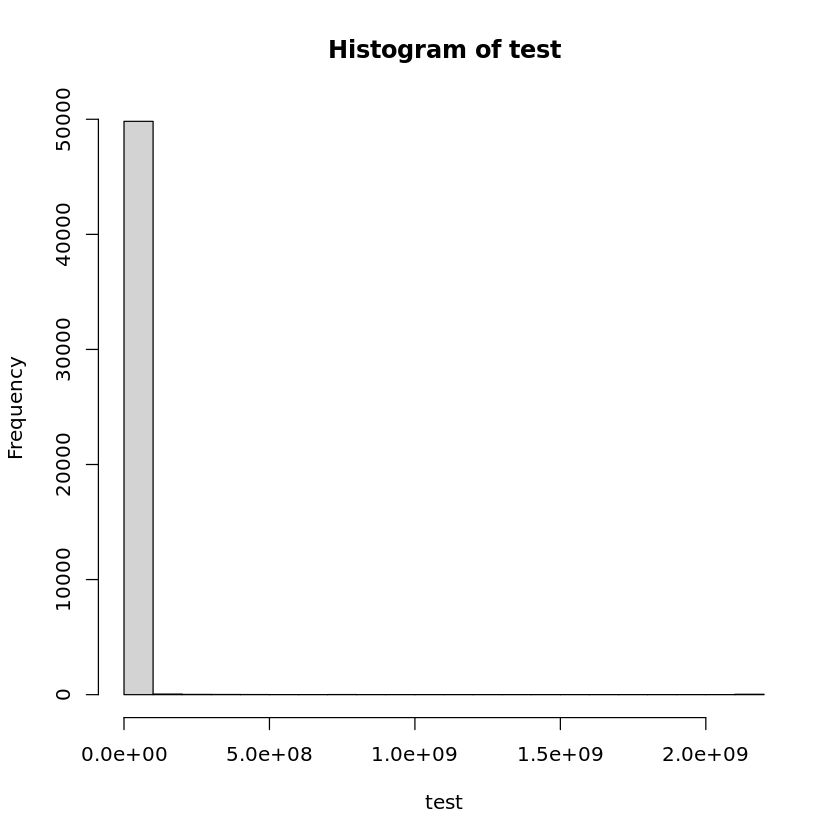

In [58]:
hist(test)

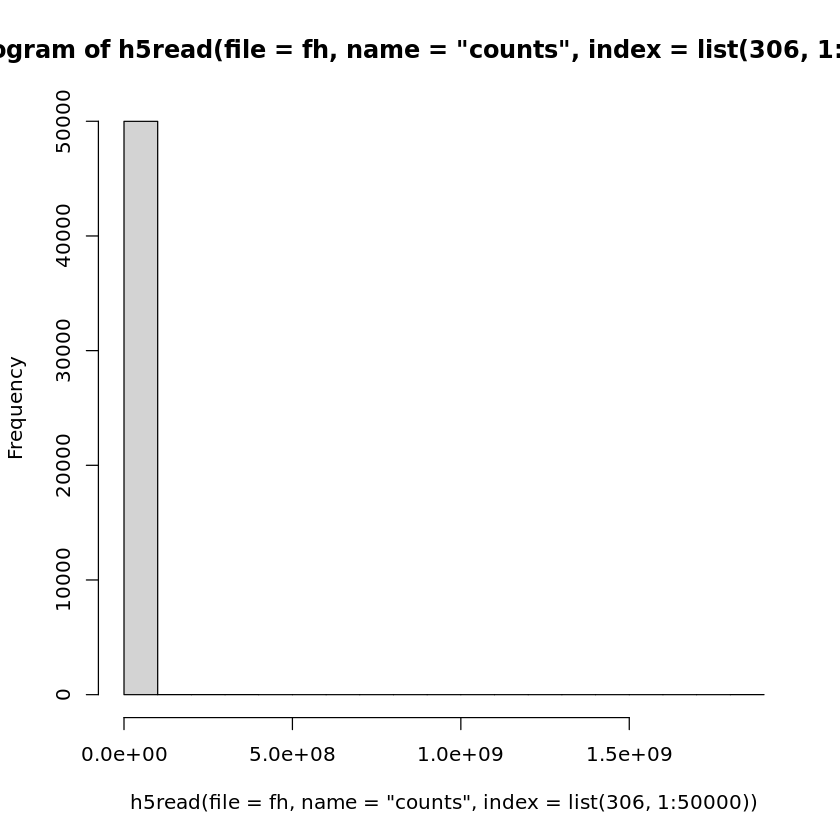

In [69]:
hist(h5read(file = fh, name = "counts", index = list(306, 1:50000)))

In [70]:
sum(h5read(file = fh, name = "counts", index = list(306, 1:50000)))

[1] 4377173532

In [72]:
h5read(file = fh, name = "counts", index = list(306, 1:50000))

0,0,0,19,0,0,0,8,0,0,⋯,0,1,1,2,0,1823,6,0,0,199628
